In [1]:
ffile = '../out/fitness.txt'
sfile = '../out/ko_scores.txt'
dfile = '../out/deviating.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [5]:
strains = ['UWOP',
           'YPS',
           'Y55']

In [6]:
m = pd.read_table(sfile, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
m = m.loc[(slice(None),
           genes,
           slice(None)),]

S288C 4889
UWOP 4014
YPS 4093
Y55 4190

total 3786


In [7]:
d = pd.read_table(dfile, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

In [8]:
f = pd.read_table(ffile)
f['absf'] = np.log2(f['relative-fitness']).abs()
order = f.groupby('condition')['absf'].max().sort_values(
    ascending=False).index

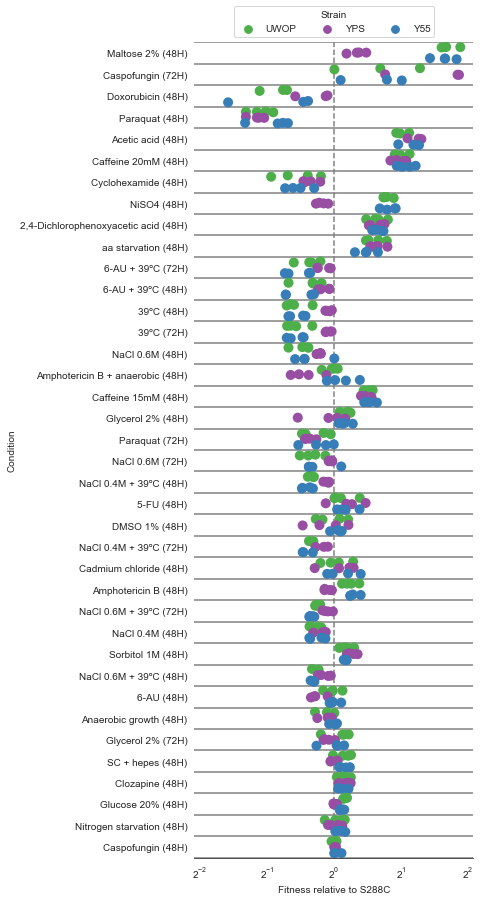

In [9]:
plt.figure(figsize=(5, 15))

sns.stripplot(data=f,
              x='relative-fitness',
              y='condition',
              hue='strain',
              order=order,
              hue_order=strains,
              palette=[cstrains[x]
                       for x in strains],
              size=10,
              dodge=True)

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.axhline(-0.5,
            color='grey')
for i in range(len(f['condition'].unique())):
    plt.axhline(i+0.5,
                color='grey')

plt.xlabel('Fitness relative to S288C')
plt.ylabel('Condition')

plt.legend(bbox_to_anchor=(0.5, 1),
           loc='lower center',
           ncol=3,
           title='Strain')

plt.xscale('log', basex=2)

sns.despine(left=True)

plt.savefig('fitness.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('fitness.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [10]:
rco = ['Caffeine 15mM (48H)',
       'aa starvation (48H)',
       'Glycerol 2% (48H)',
       'Glycerol 2% (72H)',
       'Maltose 2% (48H)',
       'NaCl 0.4M (48H)',
       'NaCl 0.6M (48H)',
       'NaCl 0.6M (72H)']
f1 = f[f['condition'].isin(rco)]
order1 = f1.groupby('condition')['absf'].max().sort_values(
    ascending=False).index

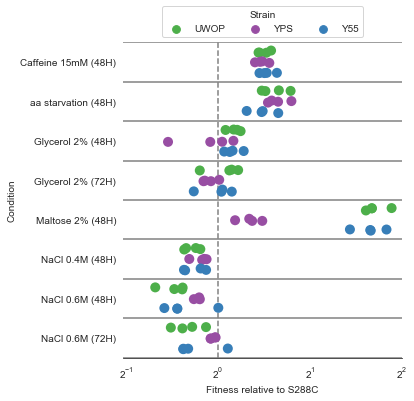

In [11]:
plt.figure(figsize=(5, 5.8))

sns.stripplot(data=f1,
              x='relative-fitness',
              y='condition',
              hue='strain',
              order=rco,
              hue_order=strains,
              palette=[cstrains[x]
                       for x in strains],
              size=10,
              dodge=True)

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.axhline(-0.5,
            color='grey')
for i in range(len(f1['condition'].unique())):
    plt.axhline(i+0.5,
                color='grey')

plt.xlabel('Fitness relative to S288C')
plt.ylabel('Condition')

plt.legend(bbox_to_anchor=(0.5, 1),
           loc='lower center',
           ncol=3,
           title='Strain')

plt.xlim(0.49, 4,1)
plt.xscale('log', basex=2)

sns.despine(left=True)

plt.savefig('fitness_zoom.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('fitness_zoom.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [12]:
res = []
for s1, s2, c in sorted({tuple(list(x[:2]) + [x[-1]])
                         for x in d.index},
                       key=lambda x: x[1]):
    y = d.loc[(s1, s2, slice(None), c), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    se1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    se2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (~x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (~x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, c, y.shape[0], p1, sh1, se1, e1, sw))
    res.append((s2, s1, c, y.shape[0], p2, sh2, se2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'condition',
                          'scores',
                          'phenotypes',
                          'shared',
                          'superexclusive',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['psuperexclusive'] = r['superexclusive'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

r = r[(r['strain'] == 'S288C') &
      (r['other'] != 'S288C')].rename(columns={'strain': 'other',
                                               'other': 'strain'})

r = r.set_index(['strain', 'condition']).sort_index()

f = f.set_index(['strain', 'condition']).sort_index()

idx = r.index.intersection(f.index)

mn = r.loc[idx].join(f.loc[idx]).reset_index()
mm = r.loc[idx].join(f.groupby(['strain', 'condition']).mean().loc[idx]).reset_index()

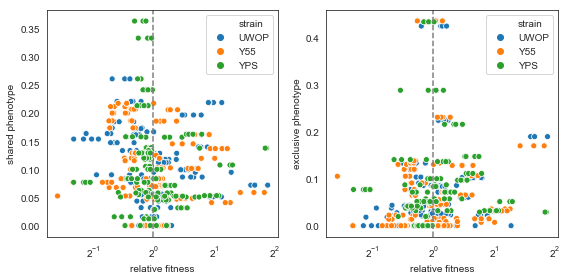

In [13]:
plt.figure(figsize=(8, 4))

plt.subplot(121)

sns.scatterplot(data=mn,
                x='relative-fitness',
                y='pshared',
                hue='strain')

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('shared phenotype')

plt.subplot(122)

sns.scatterplot(data=mn,
                x='relative-fitness',
                y='psuperexclusive',
                hue='strain')

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('exclusive phenotype')

plt.tight_layout();

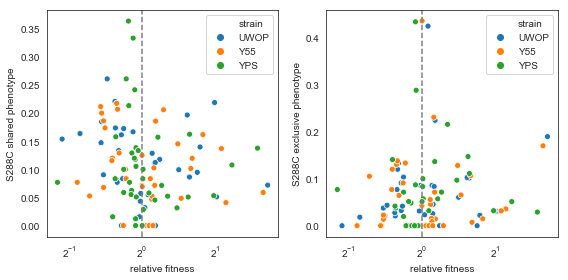

In [14]:
plt.figure(figsize=(8, 4))

plt.subplot(121)

sns.scatterplot(data=mm,
                x='relative-fitness',
                y='pshared',
                hue='strain')

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('S288C shared phenotype')

plt.subplot(122)

sns.scatterplot(data=mm,
                x='relative-fitness',
                y='psuperexclusive',
                hue='strain')

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('S288C exclusive phenotype')

plt.tight_layout();

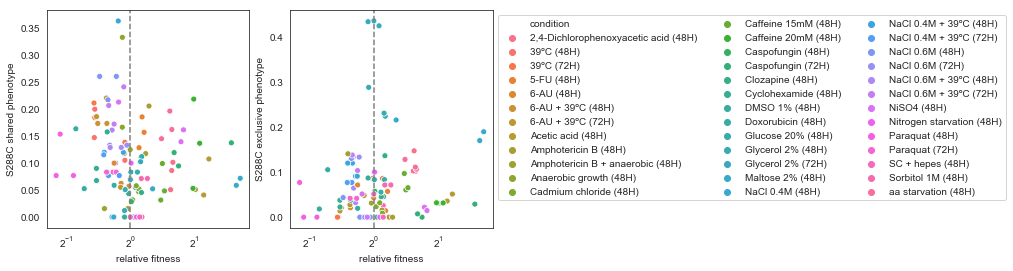

In [15]:
plt.figure(figsize=(8, 4))

plt.subplot(121)

sns.scatterplot(data=mm,
                x='relative-fitness',
                y='pshared',
                hue='condition',
                legend=False)

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('S288C shared phenotype')

plt.subplot(122)

sns.scatterplot(data=mm,
                x='relative-fitness',
                y='psuperexclusive',
                hue='condition')

plt.axvline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.xlabel('relative fitness')
plt.ylabel('S288C exclusive phenotype')

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           frameon=True,
           ncol=3);

In [16]:
a = m.groupby(['strain', 'condition'])['phenotype'].sum().sort_index()
a = (a / a.loc['S288C']).loc[strains]

In [17]:
res = []
for (strain, cond), v1 in a.iteritems():
    for v2 in f.loc[(strain, cond), 'relative-fitness'].values:
        res.append((strain, cond,
                    v1, v2))
p = pd.DataFrame(res,
                 columns=['strain',
                          'condition',
                          'phenotypes',
                          'fitness'])

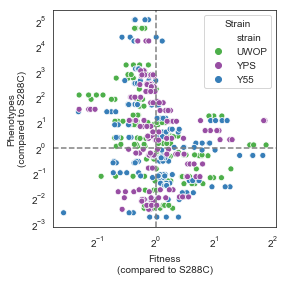

In [18]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='strain',
                hue_order=strains,
                palette=[cstrains[x]
                         for x in strains],
                data=p)

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.xlabel('Fitness\n(compared to S288C)')
plt.ylabel('Phenotypes\n(compared to S288C)')

plt.legend(title='Strain')

plt.savefig('fitness-phenotypes-all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('fitness-phenotypes-all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

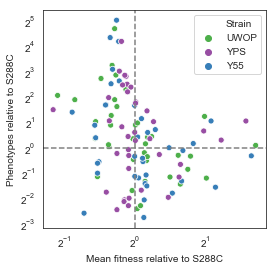

In [19]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='Strain',
                data=p.groupby(['strain', 'condition']).mean().reset_index().rename(columns={'strain': 'Strain'}),
                hue_order=strains,
                palette=[cstrains[x]
                         for x in strains])

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend(loc='upper right')

plt.xlabel('Mean fitness relative to S288C')
plt.ylabel('Phenotypes relative to S288C')

plt.savefig('fitness-phenotypes.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('fitness-phenotypes.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

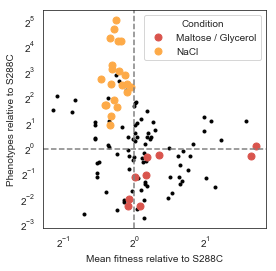

In [20]:
plt.figure(figsize=(4, 4))

df = p.groupby(['strain', 'condition']).mean().reset_index()
df['malgly'] = [True if x.startswith('Maltose') or x.startswith('Glycerol')
                else False
                for x in df['condition']]
df['nacl'] = [True if x.startswith('NaCl 0')
              else False
              for x in df['condition']]
df['caff'] = [True if x.startswith('Caffeine')
              else False
              for x in df['condition']]
df['aa'] = [True if x.startswith('aa ')
            else False
            for x in df['condition']]

plt.plot(df[(df['malgly'] == False) &
            (df['nacl'] == False) 
#             &
#             (df['caff'] == False) &
#             (df['aa'] == False)
           ]['fitness'],
         df[(df['malgly'] == False) &
            (df['nacl'] == False) 
#             &
#             (df['caff'] == False) &
#             (df['aa'] == False)
           ]['phenotypes'],
         'k.',
         label='_')
plt.plot(df[df['malgly'] == True]['fitness'],
         df[df['malgly'] == True]['phenotypes'],
         'o',
         color=sns.xkcd_rgb['pale red'],
         ms=7,
         label='Maltose / Glycerol')
plt.plot(df[df['nacl'] == True]['fitness'],
         df[df['nacl'] == True]['phenotypes'],
         'o',
         color=sns.xkcd_rgb['light orange'],
         ms=7,
         label='NaCl')
# plt.plot(df[df['caff'] == True]['fitness'],
#          df[df['caff'] == True]['phenotypes'],
#          'o',
#          color=sns.xkcd_rgb['very light brown'],
#          ms=7,
#          label='Caffeine')
# plt.plot(df[df['aa'] == True]['fitness'],
#          df[df['aa'] == True]['phenotypes'],
#          'o',
#          color=sns.xkcd_rgb['dark lime'],
#          ms=7,
#          label='aa starvation')

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend(loc='upper right',
           ncol=1,
           title='Condition')

plt.xlabel('Mean fitness relative to S288C')
plt.ylabel('Phenotypes relative to S288C')

plt.savefig('fitness-phenotypes-conditions.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('fitness-phenotypes-conditions.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

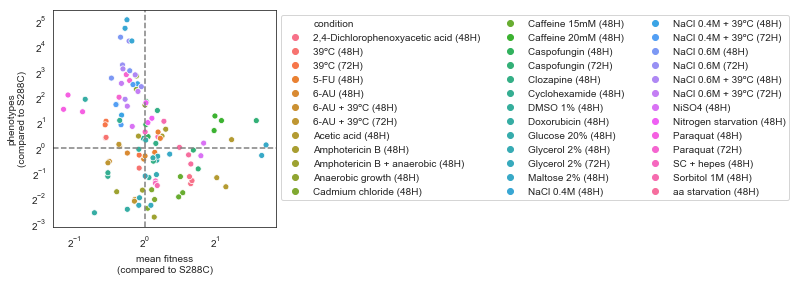

In [21]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='fitness',
                y='phenotypes',
                hue='condition',
                data=p.groupby(['strain', 'condition']).mean().reset_index())

plt.axvline(1,
            color='grey',
            ls='dashed')
plt.axhline(1,
            color='grey',
            ls='dashed')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           ncol=3)

plt.xlabel('mean fitness\n(compared to S288C)')
plt.ylabel('phenotypes\n(compared to S288C)');